In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
# from tpot import TPOTRegressor
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from featuresv2 import targets, metadata
from position_group_features import features
import json
import requests
%matplotlib inline

## Version 3 Model

In [3]:
data = pd.read_csv('outputs/model_training_data.csv')

In [4]:
data = data[data['round.year'] != 2024]

In [5]:
round_matchups = [
    ('Sydney Swans','Melbourne'),
    ('Brisbane Lions','Carlton'),
    ('Gold Coast Suns','Richmond'),
    ('GWS Giants','Collingwood')]

In [19]:
round1 = [('Sydney Swans', 'Hawthorn'),
('GWS GIANTS','Collingwood')]

In [7]:
def generate_test_train_split(data, features, target, test_size=0.3):
    X = data[features]
    y = data[target]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return {"x_train":x_train,"x_test":x_test,"y_train":y_train,"y_test":y_test}

In [8]:
def tpot_pipeline(data, features, target, size=20, scoring='r2'):
    data_ = generate_test_train_split(data, features, target)

    my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    pipeline_optimizer = TPOTRegressor(generations=5, population_size=size, verbosity=2, scoring=scoring)

    pipeline_optimizer.fit(data_['x_train'], data_['y_train'])
    
    print(pipeline_optimizer.score(data_['x_test'], data_['y_test']))
    
    return pipeline_optimizer

In [9]:
def return_stats_input(data, home_team, away_team, model_inputs, games=5):
    '''Take in player_stats and returns aggregated team stats for previous home/away team matchups'''
    
#     if 'team.name' not in model_inputs:
#         model_inputs.append('team.name')
        
    match_ups = data[(data['match.homeTeam.name']==home_team) & (data['match.awayTeam.name']==away_team)]
    weights = range(1,len(match_ups)+1)

    stats = match_ups[model_inputs+['match.homeTeam.name']].groupby('match.homeTeam.name').apply(lambda x: np.average(x, weights=weights, axis=0))
    
    return pd.DataFrame(dict(zip(model_inputs,stats[0])),index=[0])

In [10]:
def generate_margin_tear_off(model, round_matchups, team_stats, model_inputs):
    print('-------------------' + str(model.fitted_pipeline_[0]).replace('()','') + ' TEAR-OFF-------------------')
    for tup in round_matchups:
        predict = model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
        if predict < 0:
            winner = tup[1]
        else:
            winner = tup[0]
        print("------------------------------------------------")
        print("Home: " + tup[0])
        print("Away: " + tup[1])
        print("Winner: " + winner + "\t       " + "Margin: " + str(abs(round(predict))))

In [11]:
def generate_score_tear_off(home_model, away_model, round_matchups, team_stats, model_inputs):
   # print('-------------------' + str(model.fitted_pipeline_[0]).replace('()','') + ' TEAR-OFF-------------------')
    preds = []
    for tup in round_matchups:
        try:
            h_predict = home_model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
            a_predict = away_model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
            if h_predict < a_predict:
                winner = tup[1]
                margin = round(a_predict) - round(h_predict)
            else:
                winner = tup[0]
                margin = round(h_predict) - round(a_predict)
            paddingh = 25 - len("Home: " + tup[0])
            paddinga = 25 - len("Away: " + tup[1])
            print("------------------------------------------------")
            print("Home: " + tup[0] + " "*paddingh + str(abs(round(h_predict))))
            print("Away: " + tup[1] + " "*paddinga + str(abs(round(a_predict))))
            print("Winner: " + winner + " by "+ str(margin) + " points")
            print("Total Score: " + str(round(h_predict) + round(a_predict)))
            preds.append((h_predict, a_predict, margin))
        except:
            print("No prior game")
            preds.append((0, 0, 0))
    return preds

In [ ]:
def elastic_net_model(data, features, target, size=20, scoring='r2'):
    data_ = generate_test_train_split(data, features, target)
    model = ElasticNetCV(cv=size, random_state=0)
    model.fit(data_['x_train'], data_['y_train'])
    return model

In [ ]:
# home_model = tpot_pipeline(data, features, targets[0], size=10)
home_model = elastic_net_model(data, features, targets[0], size=10)

In [15]:
# away_model = tpot_pipeline(data, features, targets[1], size=10)
away_model = elastic_net_model(data, features, targets[1], size=10)

In [13]:
# margin_model = tpot_pipeline(data, features, targets[2], size=10)

In [20]:
generate_score_tear_off(home_model, away_model, round1, data, features)

------------------------------------------------
Home: Sydney Swans       82
Away: Hawthorn           62
Winner: Sydney Swans by 20 points
Total Score: 144
------------------------------------------------
Home: GWS GIANTS         87
Away: Collingwood        76
Winner: GWS GIANTS by 11 points
Total Score: 163


C:\Users\whitehes\AppData\Local\Temp\ipykernel_26964\905886690.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return pd.DataFrame(dict(zip(model_inputs,stats[0])),index=[0])
C:\Users\whitehes\AppData\Local\Temp\ipykernel_26964\905886690.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return pd.DataFrame(dict(zip(model_inputs,stats[0])),index=[0])
C:\Users\whitehes\AppData\Local\Temp\ipykernel_26964\905886690.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

[(82.30961766378549, 61.60219618787272, 20),
 (86.85294405135608, 76.00167078356837, 11)]

In [15]:
# print(return_stats_inputv3(data, home_team, away_team, features))
# generate_margin_tear_off(margin_model, round1, data, features)
# data[(data['match.homeTeam.name']==home_team) & (data['match.awayTeam.name']==away_team)][features].head()

In [11]:
fix_data_2024 = json.loads(requests.get('https://fixturedownload.com/feed/json/afl-2024').content)

fix_data_2023 = json.loads(requests.get('https://fixturedownload.com/feed/json/afl-2023').content)

fixtures2024 = pd.DataFrame(fix_data_2024)
games2024 = list(zip(fixtures2024.HomeTeam, fixtures2024.AwayTeam))

fixtures2023 = pd.DataFrame(fix_data_2023)
games2023 = list(zip(fixtures2023.HomeTeam, fixtures2023.AwayTeam))

predicted_season = generate_score_tear_off(home_model, away_model, games2024, data, features)

fixtures2024['predicted_home'] = [round(i[0]) for i in predicted_season]
fixtures2024['predicted_away'] = [round(i[1]) for i in predicted_season]

pred_winner = []
winner = []
for i, row in fixtures2024.iterrows():

    if row[7] > row[8]:
        winner.append(row[4])
    elif row[8] > row[7]:
        winner.append(row[5])
    else:
        winner.append('Draw')


    if row[9] > row[10]:
        pred_winner.append(row[4])
    elif row[10] > row[9]:
        pred_winner.append(row[5])
    else:
        pred_winner.append('Draw')

fixtures2024['predicted_winner'] = pred_winner
fixtures2024['winner'] = winner
fixtures2024['predicted_margin'] = fixtures2024['predicted_home'] - fixtures2024['predicted_away']
fixtures2024['actual_margin'] = fixtures2024['HomeTeamScore'] - fixtures2024['AwayTeamScore']
fixtures2024['correct'] = [1 if row[11]==row[12] else 0 for i,row in fixtures2024.iterrows()]
# fixtures2023['odds'] = [2.3 if abs(row[13]) < 40 else 2.6 for i,row in fixtures2023.iterrows()]


fixtures2024.to_csv('outputs/predictions_and_results_2024_.csv', index=False)

------------------------------------------------
Home: Sydney Swans       68
Away: Melbourne          71
Winner: Melbourne by 3 points
Total Score: 139
------------------------------------------------
Home: Brisbane Lions     91
Away: Carlton            70
Winner: Brisbane Lions by 21 points
Total Score: 161
------------------------------------------------
Home: Gold Coast Suns    76
Away: Richmond           91
Winner: Richmond by 15 points
Total Score: 167
------------------------------------------------
Home: GWS Giants         82
Away: Collingwood        69
Winner: GWS Giants by 13 points
Total Score: 151
------------------------------------------------
Home: Carlton            88
Away: Richmond           83
Winner: Carlton by 5 points
Total Score: 171
------------------------------------------------
Home: Collingwood        66
Away: Sydney Swans       47
Winner: Collingwood by 19 points
Total Score: 113
------------------------------------------------
Home: Essendon           100
A

------------------------------------------------
Home: GWS Giants         75
Away: Brisbane Lions     99
Winner: Brisbane Lions by 24 points
Total Score: 174
------------------------------------------------
Home: Port Adelaide      77
Away: St Kilda           52
Winner: Port Adelaide by 25 points
Total Score: 129
------------------------------------------------
Home: North Melbourne    71
Away: Adelaide Crows     95
Winner: Adelaide Crows by 24 points
Total Score: 166
------------------------------------------------
Home: Geelong Cats       94
Away: Carlton            76
Winner: Geelong Cats by 18 points
Total Score: 170
------------------------------------------------
Home: Fremantle          67
Away: Western Bulldogs   89
Winner: Western Bulldogs by 22 points
Total Score: 156
------------------------------------------------
Home: Gold Coast Suns    104
Away: West Coast Eagles  88
Winner: Gold Coast Suns by 16 points
Total Score: 192
------------------------------------------------
Ho

------------------------------------------------
Home: St Kilda           99
Away: Gold Coast Suns    65
Winner: St Kilda by 34 points
Total Score: 164
------------------------------------------------
Home: Sydney Swans       78
Away: Geelong Cats       75
Winner: Sydney Swans by 3 points
Total Score: 153
------------------------------------------------
Home: Essendon           71
Away: Carlton            81
Winner: Carlton by 10 points
Total Score: 152
------------------------------------------------
Home: Collingwood        72
Away: Melbourne          57
Winner: Collingwood by 15 points
Total Score: 129
------------------------------------------------
Home: Brisbane Lions     71
Away: St Kilda           66
Winner: Brisbane Lions by 5 points
Total Score: 137
------------------------------------------------
Home: Western Bulldogs   95
Away: Fremantle          78
Winner: Western Bulldogs by 17 points
Total Score: 173
------------------------------------------------
Home: Richmond       

------------------------------------------------
Home: Melbourne          74
Away: GWS Giants         58
Winner: Melbourne by 16 points
Total Score: 132
------------------------------------------------
Home: North Melbourne    60
Away: Geelong Cats       96
Winner: Geelong Cats by 36 points
Total Score: 156
------------------------------------------------
Home: St Kilda           82
Away: Essendon           76
Winner: St Kilda by 6 points
Total Score: 158
------------------------------------------------
Home: Sydney Swans       84
Away: Western Bulldogs   72
Winner: Sydney Swans by 12 points
Total Score: 156
------------------------------------------------
Home: Adelaide Crows     83
Away: Hawthorn           84
Winner: Hawthorn by 1 points
Total Score: 167
------------------------------------------------
Home: Fremantle          77
Away: West Coast Eagles  65
Winner: Fremantle by 12 points
Total Score: 142
------------------------------------------------
Home: Collingwood        75
Awa

In [25]:
backtest_data = pd.read_csv('outputs/predictions_and_results_2023.csv')
backtest_data.columns

Index(['MatchNumber', 'RoundNumber', 'DateUtc', 'Location', 'HomeTeam',
       'AwayTeam', 'Group', 'HomeTeamScore', 'AwayTeamScore', 'predicted_home',
       'predicted_away', 'predicted_winner', 'winner', 'predicted_margin',
       'actual_margin', 'correct', 'odds', 'win '],
      dtype='object')

In [31]:
profit_curve_no_geelong = []
bankroll = 100
stake = 0
profit = 0
for i, row in backtest_data.iterrows():
    
    if (backtest_data['predicted_winner'][i] != 'Geelong Cats') and (backtest_data['predicted_winner'][i] != 'Richmond'):
        stake = -1 * 0.1 * bankroll
        profit = -stake * backtest_data['odds'][i] * backtest_data['win '][i]
        
        bankroll+=stake+profit

        profit_curve_no_geelong.append(bankroll)
    else:
        bankroll+=0

        profit_curve_no_geelong.append(bankroll)

In [27]:
profit_curve = []
bankroll = 100
stake = 0
profit = 0
for i, row in backtest_data.iterrows():
    
    stake = -1 * 0.1 * bankroll
    profit = -stake * backtest_data['odds'][i] * backtest_data['win '][i]

    bankroll+=stake+profit

    profit_curve.append(bankroll)

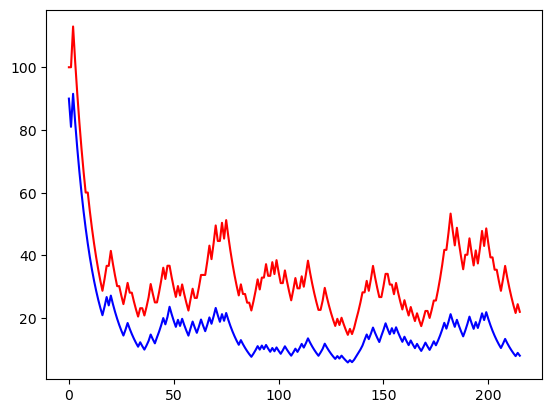

In [32]:
plt.plot(profit_curve, color='b')
plt.plot(profit_curve_no_geelong, color='r')